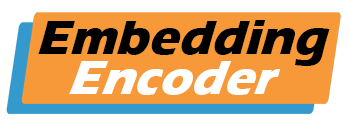

# Embedding Encoder on the Rossmann Sales dataset

This notebook demonstrates the use of Embedding Encoder on a dataset with high cardinality variables. This is a regression task with about 1 million rows, which we downsample to 20% to speed up processing.

The dataset can be downloaded from the original [Rossmann Store Sales competition on Kaggle](https://www.kaggle.com/c/rossmann-store-sales/data) below. 

## Main goals of this notebook 


1.   Create two pipelines for a regression models

> **First pipeline:** Will contain embedding encoder for processing certain columns \
**Second pipeline:** will use ordinal encoder instead


2.   Compare the scores of the two models and check if Embbeding Encoder performed better



In [1]:
!pip install embedding-encoder[full]==0.0.4

zsh:1: no matches found: embedding-encoder[full]==0.0.4


In [2]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from embedding_encoder import EmbeddingEncoder
from embedding_encoder.utils.compose import ColumnTransformerWithNames

In [4]:
store_df = pd.read_csv("data/rossmann-store-sales/store.csv")
train_df = pd.read_csv("data/rossmann-store-sales/train.csv", dtype={"StateHoliday": str})

df = train_df.merge(store_df, how="left", left_on=train_df.Store, right_on=store_df.Store)
df.drop(["key_0", "Store_y"], axis=1, inplace=True)
df = df.rename(columns={"Store_x":"Store"})

df.drop(["Promo2SinceWeek", "Promo2SinceYear", "PromoInterval"], axis=1, inplace=True)
df = df.sample(frac=0.2)
X = df.drop(["Sales", "Date"], axis=1)
y = df["Sales"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
categorical_high = ["Store", "CompetitionOpenSinceYear", "CompetitionOpenSinceMonth", "DayOfWeek"]
numeric = ["Customers", "CompetitionDistance"]
categorical_low = ["Open", "Promo", "SchoolHoliday", "Promo2", "StateHoliday", "StoreType", "Assortment"]

def build_pipeline(mode: str):
    if mode == "embeddings":
        high_cardinality_encoder = EmbeddingEncoder(task="regression")
    else:
        high_cardinality_encoder = OrdinalEncoder()
    one_hot_encoder = OneHotEncoder(handle_unknown="ignore")
    scaler = StandardScaler()
    imputer = ColumnTransformerWithNames([("numeric", SimpleImputer(strategy="mean"), numeric), ("categorical", SimpleImputer(strategy="most_frequent"), categorical_low+categorical_high)])
    processor = ColumnTransformer([("one_hot", one_hot_encoder, categorical_low), (mode, high_cardinality_encoder, categorical_high), ("scale", scaler, numeric)])
    return make_pipeline(imputer, processor, RandomForestRegressor())

embeddings_pipeline = build_pipeline("embeddings")
ordinal_pipeline = build_pipeline("ordinal")

In [7]:
embeddings_pipeline.fit(X_train, y_train)
embedding_preds = embeddings_pipeline.predict(X_test)

2023-04-02 14:24:39.317454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 14:24:40.236911: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-02 14:24:40.237019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-02 14:24:40.237029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [8]:
ordinal_pipeline.fit(X_train, y_train)
ordinal_preds = ordinal_pipeline.predict(X_test)

In [9]:
print("Model using Ordinal Encoder")
print(f"Root Mean Squeared Error: {mean_squared_error(y_test, ordinal_preds, squared=False)}")

Model using Ordinal Encoder
Root Mean Squeared Error: 585.1265083704036


In [10]:
print("Model using Embbeding Encoder")
print(f"Root Mean Squeared Error: {mean_squared_error(y_test, embedding_preds, squared=False)}")

Model using Embbeding Encoder
Root Mean Squeared Error: 545.0983512203845


<Axes: title={'center': "PCA embeddings projection for variable 'DayOfWeek'"}, xlabel='Component 0', ylabel='Component 1'>

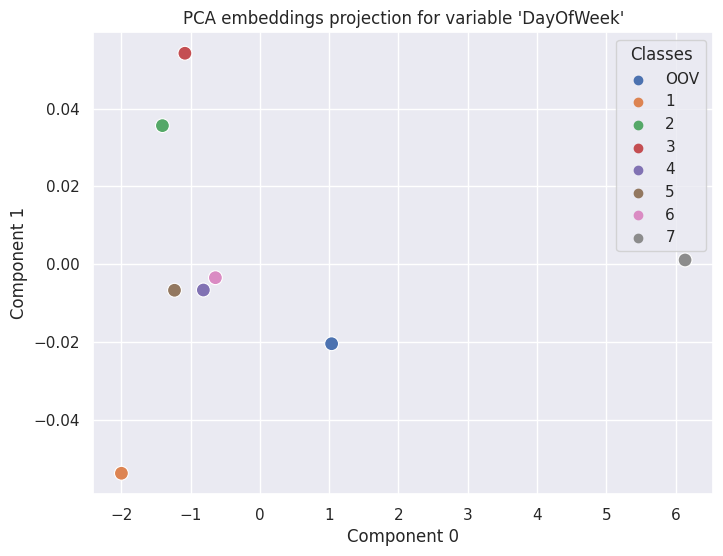

In [11]:
embeddings_pipeline.named_steps["columntransformer"].transformers_[1][1].plot_embeddings("DayOfWeek", model="pca")